In [1]:
from pathlib import Path  # For defining dataset Paths
import sys
sys.path.append("../../..")

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from umap import UMAP
#from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

# Librep imports
from librep.utils.dataset import PandasDatasetsIO          # For quick load train, test and validation CSVs
from librep.datasets.har.loaders import ExtraSensoryBalancedResampledView20HZ, UCIHARUnbalancedView, WISDMInterpolatedUnbalancedView, CHARMUnbalancedView, KuHarResampledView20HZ, MotionSenseResampledView20HZ

from librep.datasets.multimodal import PandasMultiModalDataset, TransformMultiModalDataset, WindowedTransform
from librep.transforms.fft import FFT
from librep.utils.workflow import SimpleTrainEvalWorkflow, MultiRunWorkflow
from librep.estimators import RandomForestClassifier, SVC, KNeighborsClassifier
from librep.metrics.report import ClassificationReport
from librep.transforms.resampler import SimpleResampler

2022-10-03 22:48:02.703134: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-03 22:48:02.703208: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Datasets to train the manifold

## Load Extrasensory

In [3]:
# Load ExtraSensory, creating PandasMultiModalDatasets with the correct pre-defined windows
loader = ExtraSensoryBalancedResampledView20HZ("../../../data/views/ExtraSensory/balanced_view_resampled_20hz", download=False)
train_val_es, test_es = loader.load(concat_train_validation=True)
train_val_es.data.iloc[:,1:-6]

,accelerometer-x-0,accelerometer-x-1,accelerometer-x-2,accelerometer-x-3,accelerometer-x-4,accelerometer-x-5,accelerometer-x-6,accelerometer-x-7,accelerometer-x-8,accelerometer-x-9,...,gyroscope-z-50,gyroscope-z-51,gyroscope-z-52,gyroscope-z-53,gyroscope-z-54,gyroscope-z-55,gyroscope-z-56,gyroscope-z-57,gyroscope-z-58,gyroscope-z-59
0,-0.724789,-0.507973,0.107924,-0.052122,-0.308210,-0.327109,-0.144647,-0.061857,-0.075849,-0.108986,...,-0.029486,0.011534,-0.032998,0.016543,-0.041989,0.027790,-0.045943,0.052013,-0.077395,0.111475
1,-0.013220,-0.019134,-0.002889,-0.008703,0.013098,0.018542,0.009620,0.016564,0.006461,0.004548,...,0.000029,0.004917,-0.018431,0.004122,0.019265,0.014980,0.022228,0.023919,0.028533,0.013692
2,-0.214355,-0.206973,-0.219664,-0.225939,-0.219012,-0.208570,-0.195748,-0.212864,-0.227196,-0.245031,...,0.002744,0.005068,0.010737,0.009596,0.007746,0.004763,0.013354,0.005289,0.002381,0.008331
3,0.761069,0.757731,0.752873,0.753823,0.753913,0.756301,0.758194,0.756618,0.756947,0.756485,...,0.001041,-0.000783,-0.002598,0.001302,0.000400,0.000531,-0.002842,0.000469,0.000963,-0.001895
4,-0.001454,-0.008433,-0.004865,-0.006524,-0.005949,-0.006001,-0.007217,-0.008985,-0.007185,-0.003809,...,-0.001976,-0.000086,-0.000245,0.001119,-0.001033,0.001574,-0.001405,-0.000204,-0.003032,0.002380
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,1.318814,0.820496,0.829511,1.464799,1.194766,1.340308,0.655106,0.642922,1.672151,1.631894,...,-0.071705,0.560008,0.477855,0.188169,0.514792,-0.305859,-0.512085,-0.384287,-0.300596,-0.197638
140,-3.755993,-2.862513,-2.130942,1.607675,3.116307,2.871448,1.015326,3.089434,5.513042,4.221506,...,-1.275709,-2.031439,-3.953223,-4.451037,-2.519823,-1.071030,-2.209544,-2.579949,-0.775481,0.184701
141,-0.046923,-0.052641,-0.047726,-0.048309,-0.047292,-0.043157,-0.039521,-0.041308,-0.040168,-0.044390,...,-0.006601,-0.004064,0.002956,0.005797,0.001869,-0.003331,0.004593,-0.004651,0.003989,-0.001190
142,-6.725034,-4.565210,-6.688427,-8.245128,-2.401993,6.173494,6.665963,7.925987,2.102236,-0.814744,...,7.413526,2.151802,-1.035741,0.370291,-0.468816,-1.549655,-2.854839,-5.031104,-7.418414,-6.967641


In [4]:
# Train set
extrasensory_train_X = np.array(train_val_es.data.iloc[:,1:-6])
extrasensory_train_Y = np.array(train_val_es.data['activity code'])
tam = len(extrasensory_train_Y)
extrasensory_train_id_dataset = np.array(['E']*tam)

In [5]:
# Teste set
extrasensory_test_X = np.array(test_es.data.iloc[:,1:-6])
extrasensory_test_Y = np.array(test_es.data['activity code'])
tam = len(extrasensory_test_Y)
extrasensory_test_id_dataset = np.array(['E']*tam)

## Load UCI-HAR

In [6]:
# Load UCI-HAR, creating PandasMultiModalDatasets with the correct pre-defined windows
loader = UCIHARUnbalancedView("../../../data/views/UCI-HAR/unbalanced_view_train_test-v1", download=False)
train_val_uci, test_uci = loader.load(concat_train_validation=True)

train_val_uci.data['activity code'] = train_val_uci.data['activity code'].astype('int')

In [7]:
# Resampling the dataset to 20 Hz
resampler = SimpleResampler(new_sample_size=60)
transformer = TransformMultiModalDataset(
    transforms=[resampler], new_window_name_prefix="resampled."
)
train_val_uci = transformer(train_val_uci)
test_uci = transformer(test_uci)

# Train set
uci_train_X = train_val_uci.X
uci_train_Y = train_val_uci.y

tam = len(uci_train_Y)
uci_train_id_dataset = np.array(['U']*tam)

In [8]:
# Test set

uci_test_X = test_uci.X
uci_test_Y = test_uci.y

tam = len(uci_test_Y)
uci_test_id_dataset = np.array(['U']*tam)

## Load WISDM

In [9]:
# Load WISDM and create PandasMultiModalDatasets with the correct pre-defined windows
loader = WISDMInterpolatedUnbalancedView("../../../data/views/WISDM/interpolated_unbalanced_view_train_test-v1", download=False)
train_val_wisdm, test_wisdm = loader.load(concat_train_validation=True)

#rename "activity" with "activity code"
train_val_wisdm.data.rename(columns = {'activity':'activity code'}, inplace = True)
#test.data.rename(columns = {'activity':'activity code'}, inplace = True)

train_val_wisdm.data['activity code'] = train_val_wisdm.data['activity code'].astype('int')


In [10]:
# Train set
wisdm_train_X = np.array(train_val_wisdm.data.iloc[:,:-2])
wisdm_train_Y = np.array(train_val_wisdm.data['activity code'])

tam = len(wisdm_train_Y)
wisdm_train_id_dataset = np.array(['W']*tam)

In [11]:
# Test set
wisdm_test_X = np.array(test_wisdm.data.iloc[:,:-2])
wisdm_test_Y = np.array(test_wisdm.data['activity code'])

tam = len(wisdm_test_Y)
wisdm_test_id_dataset = np.array(['W']*tam)

## Concatenate datasets

In [12]:
columns = list(train_val_wisdm.data.iloc[:,:-2].columns)
train_val_es.window_names, train_val_uci.window_names, train_val_wisdm.window_names

(['accelerometer-x',
  'accelerometer-y',
  'accelerometer-z',
  'gyroscope-x',
  'gyroscope-y',
  'gyroscope-z'],
 ['resampled.accel-x',
  'resampled.accel-y',
  'resampled.accel-z',
  'resampled.gyro-x',
  'resampled.gyro-y',
  'resampled.gyro-z'],
 ['accel-x', 'accel-y', 'accel-z', 'gyro-x', 'gyro-y', 'gyro-z'])

In [13]:
train_universal_X = np.concatenate([wisdm_train_X, uci_train_X, extrasensory_train_X])
test_universal_X = np.concatenate([wisdm_test_X, uci_test_X, extrasensory_test_X])

train_universal_X.shape, test_universal_X.shape

((14016, 360), (5645, 360))

In [14]:
train_universal_Y = np.concatenate([wisdm_train_Y, uci_train_Y, extrasensory_train_Y])
test_universal_Y = np.concatenate([wisdm_test_Y, uci_test_Y, extrasensory_test_Y])

train_universal_Y.shape, test_universal_Y.shape

((14016,), (5645,))

In [15]:
train_universal_id_dataset = np.concatenate([wisdm_train_id_dataset, uci_train_id_dataset, extrasensory_train_id_dataset])
test_universal_id_dataset = np.concatenate([wisdm_test_id_dataset, uci_test_id_dataset, extrasensory_test_id_dataset])

In [16]:
train_universal = pd.DataFrame(train_universal_X, columns=columns)
train_universal['Id Dataset'] = train_universal_id_dataset

test_universal = pd.DataFrame(test_universal_X, columns=columns)
test_universal['Id Dataset'] = test_universal_id_dataset

In [17]:
# Preaper the train and test universal datasets
# Features to select
features = [
    "accel-x",
    "accel-y",
    "accel-z",
    "gyro-x",
    "gyro-y",
    "gyro-z"
]

# Creating the datasets

# Train
train_universal = PandasMultiModalDataset(
    train_universal,
    feature_prefixes=features,
    label_columns="Id Dataset",
    as_array=True
)

# Test
test_universal = PandasMultiModalDataset(
    test_universal,
    feature_prefixes=features,
    label_columns="Id Dataset",
    as_array=True
)

# Training universal UMAP

In [18]:
fft_transform = FFT()

# Compose the transform
# First apply the normalizer over whole dataset and then apply FFT over each window
transformer = TransformMultiModalDataset(
    transforms=[#scaler_transform,
                fft_transform], new_window_name_prefix="scaled."
)

# Transform it and generate a new dataset!
train_universal_fft = transformer(train_universal)
test_fft = transformer(test_universal)

umap = UMAP(n_components=10, random_state=42)
umap.fit(train_universal_fft[:][0])

UMAP(n_components=10, random_state=42, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

# Datasets to evaluate the manifold

## Train in KuHar and test in KuHar

### Load KuHar

In [19]:
# Path for KuHar resampled to 20Hz view with the same activities (and labels numbers)
# It is assumed that the directory will contain (train.csv, test.csv and validation.csv)
#dataset_path = Path("../../../../data/views/KuHar/resampled_view_20Hz")
loader = KuHarResampledView20HZ("../../../data/views/KuHar/balanced_motionsense_equivalent_view", download=False)
train_val_kh, test_kh = loader.load(concat_train_validation=True)

In [20]:
# Resampling the dataset to 20 Hz
resampler = SimpleResampler(new_sample_size=60)
transformer = TransformMultiModalDataset(
    transforms=[resampler], new_window_name_prefix="resampled."
)
train_val_kh = transformer(train_val_kh)
test_kh = transformer(test_kh)

In [21]:
train_val_kh

In [22]:
# Train Set
kuhar_train_X = train_val_kh.X
kuhar_train_Y = train_val_kh.y
tam = len(kuhar_train_Y)
kuhar_train_id_dataset = np.array(['K']*tam)

In [23]:
# Test Set
kuhar_test_X = test_kh.X
kuhar_test_Y = test_kh.y
tam = len(kuhar_test_Y)
kuhar_test_id_dataset = np.array(['K']*tam)

In [24]:
# Establish out train_X, train_Y, test_X and test_Y
train_X = train_val_kh.X
train_Y = train_val_kh.y
train_id_dataset = kuhar_train_id_dataset

test_X = kuhar_test_X
test_Y = kuhar_test_Y
test_id_dataset = kuhar_test_id_dataset

In [25]:
# Train set to classifiers
train = pd.DataFrame(train_X, columns=columns)
train['normalized activity code'] = train_Y
train['Id Dataset'] = train_id_dataset

# Test set to classifiers
test = pd.DataFrame(test_X, columns=columns)
test['normalized activity code'] = test_Y
test['Id Dataset'] = test_id_dataset

In [26]:
# Features to select
features = [
    "accel-x",
    "accel-y",
    "accel-z",
    "gyro-x",
    "gyro-y",
    "gyro-z"
]

# Creating the datasets

# Train
train = PandasMultiModalDataset(
    train,
    feature_prefixes=features,
    label_columns="normalized activity code",
    as_array=True
)

# Test
test = PandasMultiModalDataset(
    test,
    feature_prefixes=features,
    label_columns="normalized activity code",
    as_array=True
)

### Evaluate in KuHar

In [27]:
# Create the objects
umap_transform = WindowedTransform(
   transform=umap, fit_on=None, transform_on="all")

fft_transform = FFT()

# Compose the transform
# First apply the normalizer over whole dataset and then apply FFT over each window
transformer = TransformMultiModalDataset(
    transforms=[fft_transform, 
                umap_transform], new_window_name_prefix="reduced."
)

In [28]:
# Transform it and generate a new dataset!
train_reduced = transformer(train)
test_reduced = transformer(test)

In [29]:
# Checking the whole data...
train_reduced[:][0]

array([[14.78011   ,  5.2313337 ,  0.21644014, ...,  2.7487314 ,
         7.470162  ,  6.6919055 ],
       [10.509583  ,  5.359774  ,  2.1349237 , ...,  4.094182  ,
        14.334324  ,  6.96285   ],
       [14.7879715 ,  5.2257485 ,  0.21767156, ...,  2.7383277 ,
         7.4781127 ,  6.706112  ],
       ...,
       [10.411566  ,  5.098243  ,  2.5409162 , ...,  4.1732764 ,
        14.036336  ,  7.902488  ],
       [ 5.425561  ,  5.7942734 ,  2.1431894 , ..., 10.471475  ,
         6.7301292 ,  5.6122217 ],
       [10.212724  ,  5.2091494 ,  2.4531543 , ...,  4.395811  ,
        14.006589  ,  8.326662  ]], dtype=float32)

## Classification

In [30]:
# The reporter will be the same

reporter = ClassificationReport(
    use_accuracy=True,
    use_f1_score=True,
    use_classification_report=True,
    use_confusion_matrix=True,
    plot_confusion_matrix=True,
    # normalize='true'
)

### Random Forest

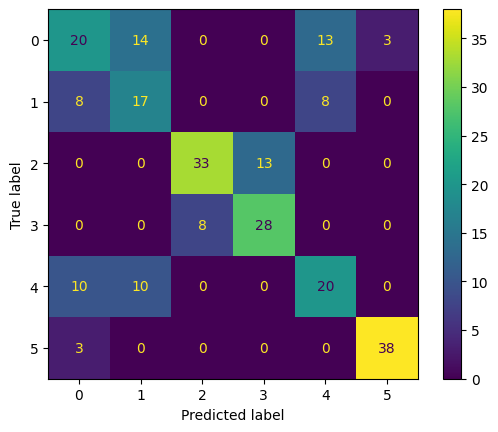

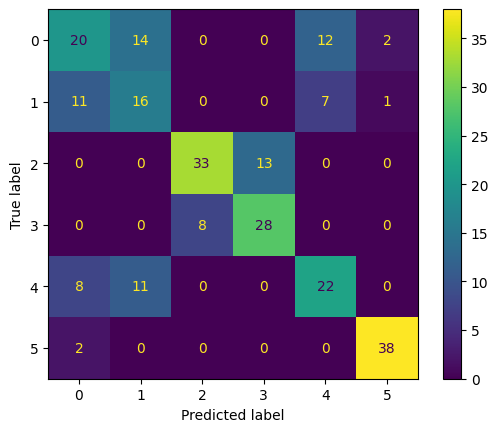

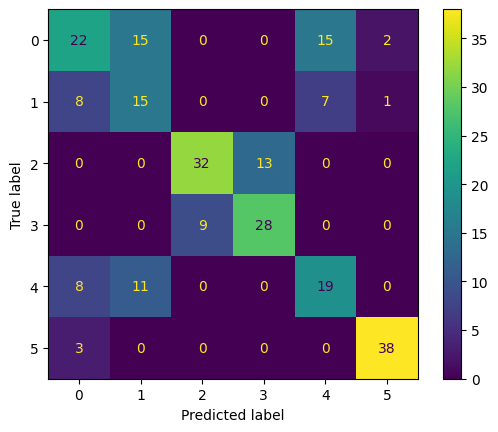

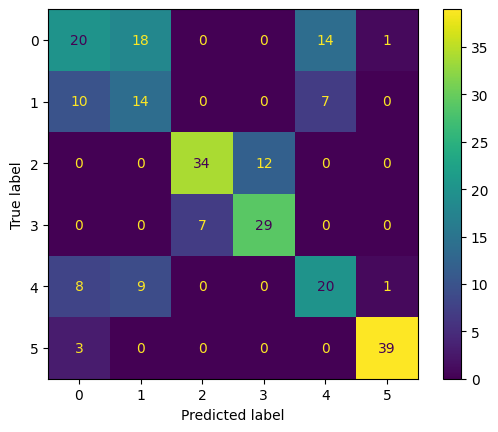

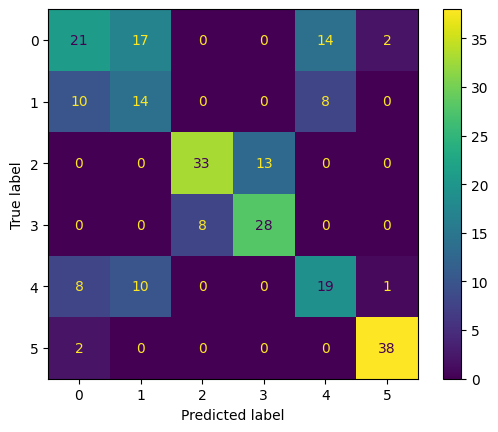

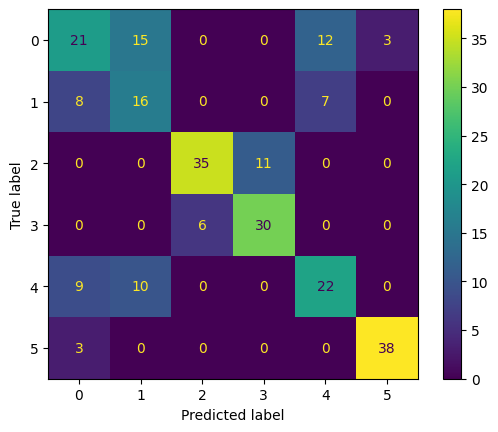

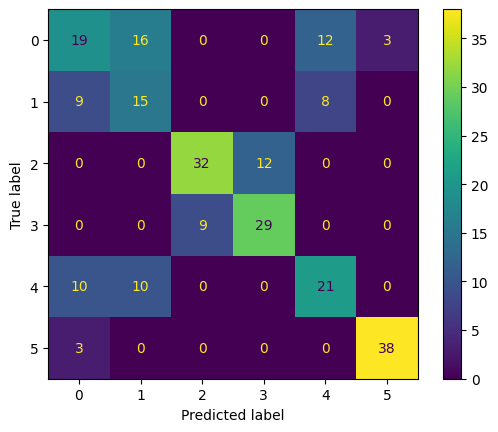

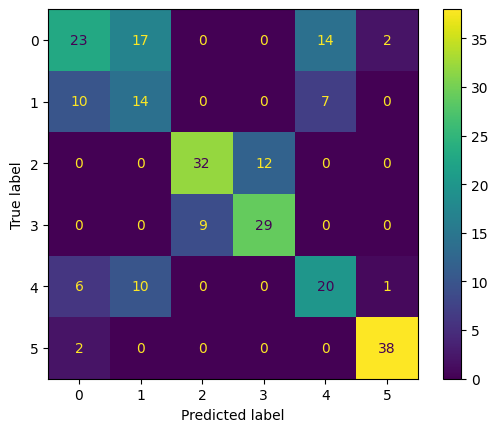

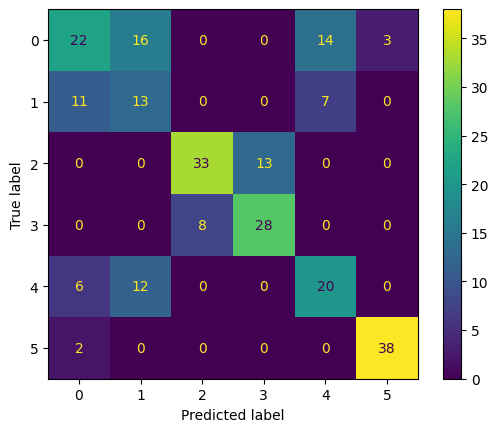

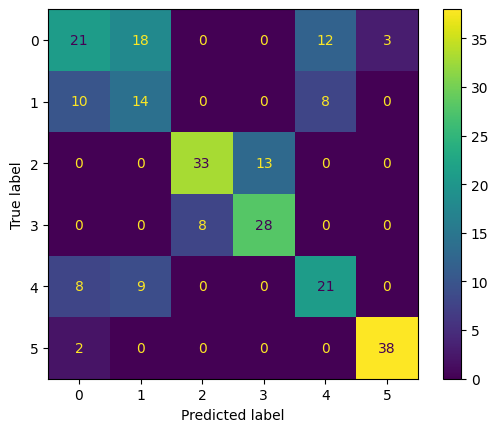

Mean accuracy (10 runs): 0.6329. Mean f1-score: 0.6334.Std accuracy (10 runs): 0.0098. Std f1-score: 0.0098


In [31]:
experiment = SimpleTrainEvalWorkflow(
    estimator=RandomForestClassifier,
    do_not_instantiate=False,
    do_fit=True,
    evaluator=reporter,
)

multi_run_experiment = MultiRunWorkflow(workflow=experiment, num_runs=10, debug=False)
results = multi_run_experiment(train_reduced, [test_reduced])

mean_acc = np.average(
    [res["result"][0]["accuracy"] for res in results["runs"]]
)

std_acc = np.std(
    [res["result"][0]["accuracy"] for res in results["runs"]]
)

mean_f1 = np.average(
    [res["result"][0]["f1 score (weighted)"] for res in results["runs"]]
)
std_f1 = np.std(
    [res["result"][0]["f1 score (weighted)"] for res in results["runs"]]
)

print(f"Mean accuracy (10 runs): {mean_acc:.4f}. Mean f1-score: {mean_f1:.4f}.Std accuracy (10 runs): {std_acc:.4f}. Std f1-score: {std_f1:.4f}")

### SVM

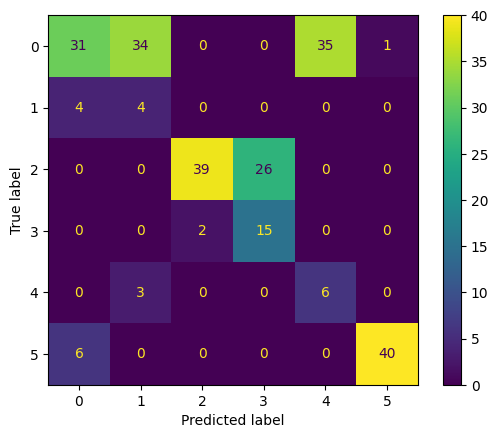

Mean accuracy (1 runs): 0.5488. Mean f1-score: 0.5955.Std accuracy (1 runs): 0.0000. Std f1-score: 0.0000


In [32]:
experiment = SimpleTrainEvalWorkflow(
    estimator=SVC,
    do_not_instantiate=False,
    do_fit=True,
    evaluator=reporter,
)

multi_run_experiment = MultiRunWorkflow(workflow=experiment, num_runs=1, debug=False)
results = multi_run_experiment(train_reduced, [test_reduced])

mean_acc = np.average(
    [res["result"][0]["accuracy"] for res in results["runs"]]
)

std_acc = np.std(
    [res["result"][0]["accuracy"] for res in results["runs"]]
)

mean_f1 = np.average(
    [res["result"][0]["f1 score (weighted)"] for res in results["runs"]]
)
std_f1 = np.std(
    [res["result"][0]["f1 score (weighted)"] for res in results["runs"]]
)

print(f"Mean accuracy (1 runs): {mean_acc:.4f}. Mean f1-score: {mean_f1:.4f}.Std accuracy (1 runs): {std_acc:.4f}. Std f1-score: {std_f1:.4f}")

### KNN

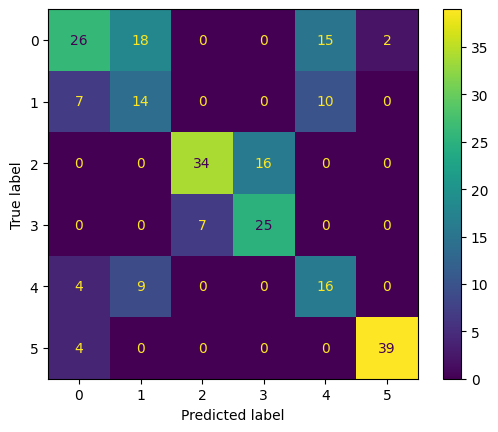

Mean accuracy (1 runs): 0.6260. Mean f1-score: 0.6326.Std accuracy (1 runs): 0.0000. Std f1-score: 0.0000


In [33]:
experiment = SimpleTrainEvalWorkflow(
    estimator=KNeighborsClassifier,
    do_not_instantiate=False,
    do_fit=True,
    evaluator=reporter,
)

multi_run_experiment = MultiRunWorkflow(workflow=experiment, num_runs=1, debug=False)
results = multi_run_experiment(train_reduced, [test_reduced])

mean_acc = np.average(
    [res["result"][0]["accuracy"] for res in results["runs"]]
)

std_acc = np.std(
    [res["result"][0]["accuracy"] for res in results["runs"]]
)

mean_f1 = np.average(
    [res["result"][0]["f1 score (weighted)"] for res in results["runs"]]
)
std_f1 = np.std(
    [res["result"][0]["f1 score (weighted)"] for res in results["runs"]]
)

print(f"Mean accuracy (1 runs): {mean_acc:.4f}. Mean f1-score: {mean_f1:.4f}.Std accuracy (1 runs): {std_acc:.4f}. Std f1-score: {std_f1:.4f}")